# Best Model
The purpose of this notebook is to take the top performing models run them on what we believe to be the most effective data. We then search through the hyperparameter space of the models to try and optimise F1 measure

In [1]:
import pandas as pd
import numpy as np
from os import path
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import shap
from hyperopt import fmin, tpe, hp
from tabpfn import TabPFNClassifier
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/ygh302/ukase_data_challenge/.venv39/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ygh302/ukase_data_challenge/.venv39/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## Load and Process Data

In [2]:
target_column = "label"
# # random
# columns_to_keep_full = [
#     "label",
#     "DPC_FS_HA",
#     "CTDC_charge.G1_PB2",
#     "ATTCC_HA",
#     "TG_NS1",
#     "CTDC_hydrophobicity_ARGP820101.G2_PB2",
#     "CAC_HA",
#     "DPC_MV_M1",
#     "CTDT_hydrophobicity_ZIMJ680101.Tr1331_PB1",
#     "CTDC_normwaalsvolume.G1_PB2",
#     "TA_NP",
#     "CTDT_secondarystruct.Tr1221_NS1",
#     "PAAC_Xc1.Y_NA",
#     "AAGGC_M1",
#     "CTDC_hydrophobicity_CASG920101.G1_PB2",
#     "ATTG_PA",
#     "TGATAC_NS1",
#     "PAAC_Xc1.R_PB2",
#     "CTDD_secondarystruct.1.residue100_HA",
#     "TT_PA",
#     "CTDC_polarizability.G1_PA",
#     "CTDT_solventaccess.Tr2332_PA",
#     "CTDC_hydrophobicity_ZIMJ680101.G1_PB1",
#     "CTCG_PB1",
#     "CTDT_normwaalsvolume.Tr1331_NA",
#     "AC_NA",
#     "GTC_NP",
# ]

# # Full Features
columns_to_keep = [
    "label",
    "AC_NA",
    "CT_NP",
    "TT_PA",
    "CTDC_hydrophobicity_PONP930101.G2_HA",
    "CTDC_hydrophobicity_ENGD860101.G2_HA",
    "CTDC_polarizability.G1_HA",
    "CTDC_hydrophobicity_ZIMJ680101.G1_HA",
    "CTDC_secondarystruct.G1_HA",
    "CTDC_solventaccess.G1_HA",
    "CTDC_charge.G1_M1",
    "CTDC_hydrophobicity_ZIMJ680101.G2_NA",
    "CTDC_hydrophobicity_PRAM900101.G1_NP",
    "CTDC_hydrophobicity_CASG920101.G3_NS1",
    "CTDC_polarizability.G2_PA",
    "CTDC_hydrophobicity_ARGP820101.G1_PB1",
    "CTDC_hydrophobicity_ARGP820101.G1_PB2",
    "CTDD_hydrophobicity_ARGP820101.1.residue75_PB2",
    "CTDD_hydrophobicity_CASG920101.1.residue75_PB2",
    "CTDD_polarity.1.residue75_PB2",
    "CTDD_charge.3.residue75_PB2",
    "CTDD_hydrophobicity_ARGP820101.1.residue50_PB2",
    "CTDD_hydrophobicity_FASG890101.2.residue0_HA",
    "CTDD_hydrophobicity_PRAM900101.2.residue50_HA",
    "CTDD_polarity.2.residue50_HA",
    "CTDD_hydrophobicity_PONP930101.2.residue50_HA",
    "CTDD_hydrophobicity_PONP930101.1.residue75_HA",
    "CTDD_hydrophobicity_PONP930101.1.residue50_HA",
    "CTDD_hydrophobicity_ENGD860101.3.residue75_PB2",
    "CTDD_polarizability.1.residue50_PB2",
    "CTDD_solventaccess.3.residue75_PB2",
    "CTDD_normwaalsvolume.3.residue75_PB2",
    "CTDD_secondarystruct.3.residue0_HA",
    "CTDD_hydrophobicity_ZIMJ680101.1.residue50_M1",
    "CTDD_secondarystruct.3.residue100_NA",
    "CTDD_normwaalsvolume.3.residue25_NP",
    "CTDD_normwaalsvolume.2.residue75_NS1",
    "CTDD_hydrophobicity_ARGP820101.2.residue50_PA",
    "CTDT_secondarystruct.Tr1331_HA",
    "CTDT_normwaalsvolume.Tr2332_HA",
    "CTDT_hydrophobicity_ARGP820101.Tr1331_HA",
    "CTDT_hydrophobicity_ARGP820101.Tr1221_HA",
    "CTDT_charge.Tr2332_PB2",
    "CTDT_hydrophobicity_PONP930101.Tr2332_PB2",
    "CTDT_secondarystruct.Tr1221_PB2",
    "CTDT_hydrophobicity_ZIMJ680101.Tr1221_PB2",
    "CTDT_hydrophobicity_FASG890101.Tr1221_PB2",
    "CTDT_solventaccess.Tr1221_PB2",
    "CTDT_hydrophobicity_FASG890101.Tr1331_PB2",
    "CTDT_charge.Tr1221_PB2",
    "CTDT_hydrophobicity_ZIMJ680101.Tr2332_PB2",
    "CTDT_normwaalsvolume.Tr2332_PB2",
    "CTDT_hydrophobicity_FASG890101.Tr1221_HA",
    "CTDT_polarity.Tr2332_HA",
    "CTDT_secondarystruct.Tr1221_HA",
    "CTDT_hydrophobicity_PONP930101.Tr1221_HA",
    "CTDT_hydrophobicity_FASG890101.Tr1331_HA",
    "CTDT_solventaccess.Tr2332_HA",
    "CTDT_hydrophobicity_ENGD860101.Tr2332_HA",
    "CTDT_solventaccess.Tr1221_M1",
    "CTDT_hydrophobicity_ZIMJ680101.Tr1221_NA",
    "CTDT_normwaalsvolume.Tr1331_NP",
    "CTDT_secondarystruct.Tr1221_NS1",
    "CTDT_polarizability.Tr1331_PA",
    "CTDT_hydrophobicity_ZIMJ680101.Tr2332_PB1",
    "CTDT_polarizability.Tr2332_PB2",
    "CTriad_g6.g6.g6_HA",
    "CTriad_g3.g4.g5_HA",
    "CTriad_g6.g1.g3_HA",
    "CTriad_g3.g3.g3_HA",
    "CTriad_g2.g2.g2_HA",
    "CTriad_g5.g4.g1_HA",
    "CTriad_g2.g2.g5_HA",
    "CTriad_g1.g4.g7_HA",
    "CTriad_g4.g1.g1_HA",
    "CTriad_g2.g5.g4_PB2",
    "CTriad_g1.g5.g1_PB2",
    "CTriad_g5.g3.g5_PB2",
    "CTriad_g2.g6.g4_PB2",
    "CTriad_g3.g3.g5_PB2",
    "CTriad_g1.g1.g3_PB2",
    "CTriad_g4.g4.g5_M1",
    "CTriad_g6.g6.g5_NA",
    "CTriad_g5.g1.g1_NP",
    "CTriad_g2.g6.g2_NS1",
    "CTriad_g2.g1.g7_PA",
    "CTriad_g4.g5.g3_PB1",
    "DPC_KQ_PB2",
    "DPC_PK_PB2",
    "DPC_GR_PB2",
    "DPC_AS_PB2",
    "DPC_AK_PB2",
    "DPC_KS_PB2",
    "DPC_MM_PB2",
    "DPC_RV_PB2",
    "DPC_IP_HA",
    "DPC_FS_HA",
    "DPC_EQ_HA",
    "DPC_LW_HA",
    "DPC_RN_HA",
    "DPC_YI_HA",
    "DPC_DW_HA",
    "DPC_VH_HA",
    "DPC_SA_HA",
    "DPC_SP_HA",
    "DPC_KR_M1",
    "DPC_DE_NA",
    "DPC_NE_NP",
    "DPC_HI_NS1",
    "DPC_AA_PA",
    "DPC_PM_PB1",
    "DPC_RT_PB2",
    "PAAC_Xc1.F_HA",
    "PAAC_Xc1.P_M1",
    "PAAC_Xc1.Y_NA",
    "PAAC_Xc1.F_NS1",
    "PAAC_Xc1.E_PB1",
    "PAAC_Xc1.F_PB2",
    "CC_HA",
    "AT_PA",
    "CT_PB1",
    "CTriad_g1.g1.g5_PB2",
    "PAAC_Xc1.C_PA",
    "PAAC_Xc1.D_PB1",
    "PAAC_Xc1.V_PB2",
]

# # Full Features 2
# columns_to_keep = [
#     "label",
#     "AC_HA",
#     "AC_M1",
#     "AC_NA",
#     "AC_PB2",
#     "AG_NS1","AG_PB1","AT_PA","CA_PB2","CC_HA","CC_PB2","CT_NP","CT_PB1","CT_PB2","CTDC_charge.G1_M1","CTDC_charge.G1_PB2","CTDC_hydrophobicity_ARGP820101.G1_PB1","CTDC_hydrophobicity_ARGP820101.G1_PB2","CTDC_hydrophobicity_ARGP820101.G2_PB2","CTDC_hydrophobicity_CASG920101.G3_NS1","CTDC_hydrophobicity_PONP930101.G2_NA","CTDC_hydrophobicity_PRAM900101.G1_NP","CTDC_hydrophobicity_ZIMJ680101.G1_M1","CTDC_hydrophobicity_ZIMJ680101.G2_NA","CTDC_hydrophobicity_ZIMJ680101.G2_PA","CTDC_hydrophobicity_ZIMJ680101.G3_HA","CTDC_normwaalsvolume.G1_NS1","CTDC_polarizability.G1_PA","CTDC_polarizability.G2_PA","CTDC_polarizability.G3_NP","CTDC_solventaccess.G1_HA","CTDC_solventaccess.G3_PB1","CTDD_charge.1.residue50_PB1","CTDD_charge.2.residue25_PB1","CTDD_charge.3.residue75_PB2","CTDD_hydrophobicity_ARGP820101.1.residue50_PA","CTDD_hydrophobicity_ARGP820101.1.residue75_PB2","CTDD_hydrophobicity_ARGP820101.2.residue50_PA","CTDD_hydrophobicity_CASG920101.2.residue50_PA","CTDD_hydrophobicity_CASG920101.2.residue75_NA","CTDD_hydrophobicity_CASG920101.3.residue75_NS1","CTDD_hydrophobicity_ENGD860101.3.residue75_PB2","CTDD_hydrophobicity_FASG890101.2.residue0_HA","CTDD_hydrophobicity_PONP930101.1.residue75_NS1","CTDD_hydrophobicity_PONP930101.2.residue0_PB1","CTDD_hydrophobicity_PONP930101.2.residue50_HA","CTDD_hydrophobicity_PRAM900101.2.residue75_M1","CTDD_hydrophobicity_ZIMJ680101.1.residue50_M1","CTDD_hydrophobicity_ZIMJ680101.2.residue75_NA","CTDD_hydrophobicity_ZIMJ680101.2.residue75_NP","CTDD_normwaalsvolume.2.residue75_NS1","CTDD_normwaalsvolume.3.residue25_NP","CTDD_polarizability.1.residue50_PB2","CTDD_secondarystruct.3.residue0_HA","CTDD_secondarystruct.3.residue100_NA","CTDD_solventaccess.3.residue100_M1","CTDT_charge.Tr1221_PB2","CTDT_hydrophobicity_ARGP820101.Tr1221_NP","CTDT_hydrophobicity_CASG920101.Tr1221_NS1","CTDT_hydrophobicity_ENGD860101.Tr2332_HA","CTDT_hydrophobicity_ENGD860101.Tr2332_NA","CTDT_hydrophobicity_PONP930101.Tr1221_HA","CTDT_hydrophobicity_PONP930101.Tr2332_M1","CTDT_hydrophobicity_ZIMJ680101.Tr1221_NA","CTDT_hydrophobicity_ZIMJ680101.Tr2332_PB1","CTDT_normwaalsvolume.Tr1331_NP","CTDT_polarizability.Tr1331_NP","CTDT_polarizability.Tr1331_PA","CTDT_polarizability.Tr2332_PB2","CTDT_secondarystruct.Tr1221_NS1","CTDT_solventaccess.Tr1221_M1","CTriad_g1.g1.g1_NP","CTriad_g1.g1.g5_PB2","CTriad_g1.g2.g6_NS1","CTriad_g1.g4.g1_NA","CTriad_g1.g4.g7_HA","CTriad_g1.g6.g1_M1","CTriad_g2.g1.g7_PA","CTriad_g2.g2.g2_PB1","CTriad_g2.g6.g2_NS1","CTriad_g2.g6.g4_PB2","CTriad_g3.g2.g7_PA","CTriad_g3.g3.g3_HA","CTriad_g3.g3.g3_M1","CTriad_g3.g3.g3_NA","CTriad_g3.g6.g1_NS1","CTriad_g4.g3.g4_PA","CTriad_g4.g4.g5_M1","CTriad_g4.g5.g3_PB1","CTriad_g5.g1.g1_NP","CTriad_g5.g3.g3_PB1","CTriad_g6.g1.g3_HA","CTriad_g6.g4.g6_NP","CTriad_g6.g6.g5_NA","CTriad_g6.g6.g6_HA","DPC_AA_PA","DPC_AS_PB2","DPC_DE_NA","DPC_DN_NA","DPC_EE_NS1","DPC_EQ_HA","DPC_FS_HA","DPC_GI_NP","DPC_HI_NS1","DPC_IE_M1","DPC_KQ_PB2","DPC_KR_M1","DPC_NE_NP","DPC_PM_PB1","DPC_PV_NA","DPC_QL_PA","DPC_RT_PB2","DPC_SP_HA","DPC_VD_M1","DPC_VQ_PB1","DPC_YR_NP","GG_NS1","PAAC_Xc1.C_PA","PAAC_Xc1.D_PB1","PAAC_Xc1.E_NP","PAAC_Xc1.E_NS1","PAAC_Xc1.E_PA","PAAC_Xc1.E_PB1","PAAC_Xc1.F_HA","PAAC_Xc1.F_NS1","PAAC_Xc1.F_PB2","PAAC_Xc1.I_HA","PAAC_Xc1.P_M1","PAAC_Xc1.R_NP","PAAC_Xc1.S_M1","PAAC_Xc1.V_NA","PAAC_Xc1.V_PB2","PAAC_Xc1.Y_NA","PAAC_Xc2.lambda3_NP","TA_M1","TC_NP","TG_M1","TT_PA"
# ]

In [3]:
# columns_to_keep = list(set(columns_to_keep_full_full).union(set(columns_to_keep_full)))
# difference_of_columns = list(set(columns_to_keep_full).difference(set(columns_to_keep_full_full)))

In [4]:
def prepare_dataframe_for_ml(df, target_column=None, one_hot_encode=True):
    """
    Prepare a pandas DataFrame for machine learning algorithms.
    - Normalizes numerical features
    - Optionally one-hot encodes categorical features
    - Optionally separates target variable

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame to prepare
    target_column : str, optional
        Name of the target column to separate
    one_hot_encode : bool, optional
        Whether to one-hot encode categorical features

    Returns:
    --------
    df_processed: pandas.DataFrame
        The processed DataFrame
    """

    # Create a copy of the dataframe to avoid modifying the original
    df_processed = df.copy()

    # Separate target if specified
    y = None
    if target_column and target_column in df_processed.columns:
        y = df_processed[target_column].replace({"nz": 0, "hzoon": 1})
        df_processed = df_processed.drop(columns=[target_column])

    # Identify numerical and categorical columns
    numerical_cols = df_processed.select_dtypes(
        include=["int64", "float64"]
    ).columns.tolist()
    categorical_cols = df_processed.select_dtypes(
        include=["object", "category", "bool"]
    ).columns.tolist()

    # Handle missing values
    df_processed[numerical_cols] = df_processed[numerical_cols].fillna(
        df_processed[numerical_cols].median()
    )
    for col in categorical_cols:
        df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0])

    # Normalize numerical features
    if numerical_cols:
        scaler = StandardScaler()
        df_processed[numerical_cols] = scaler.fit_transform(
            df_processed[numerical_cols]
        )

    # One-hot encode categorical features
    if categorical_cols and one_hot_encode:
        df_processed = pd.get_dummies(
            df_processed, columns=categorical_cols, drop_first=False
        )

    # If we have a target column, add it back to the processed dataframe
    if target_column and y is not None:
        df_processed[target_column] = y

    return df_processed

In [5]:
def remove_unimportant_columns(dataframe, columns_to_keep):
    return dataframe[columns_to_keep]

### Get test and training

In [6]:
training_data_file = path.join("..", "split_data", "full_full_data_with_species_and_locations_before_2015.csv")
test_data_file = path.join("..", "split_data", "full_full_data_with_species_and_locations_after_2015.csv")

In [7]:
training_data = pd.read_csv(training_data_file)
processed_training_data = remove_unimportant_columns(training_data, columns_to_keep)
processed_training_data = prepare_dataframe_for_ml(processed_training_data, target_column=target_column)

/tmp/ipykernel_730444/3979001912.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df_processed[target_column].replace({"nz": 0, "hzoon": 1})
/tmp/ipykernel_730444/3979001912.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_processed[target_column] = y


In [8]:
y_train = processed_training_data["label"]
X_train = processed_training_data.drop(columns=["label"])

In [9]:
test_data = pd.read_csv(training_data_file)
processed_test_data = remove_unimportant_columns(test_data, columns_to_keep)
processed_test_data = prepare_dataframe_for_ml(processed_test_data, target_column=target_column)

/tmp/ipykernel_730444/3979001912.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df_processed[target_column].replace({"nz": 0, "hzoon": 1})
/tmp/ipykernel_730444/3979001912.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_processed[target_column] = y


In [10]:
y_test = processed_test_data["label"]
X_test = processed_test_data.drop(columns=["label"])

### Handle Imbalance

In [11]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

/home/ygh302/ukase_data_challenge/.venv39/lib64/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/ygh302/ukase_data_challenge/.venv39/lib64/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/ygh302/ukase_data_challenge/.venv39/lib64/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


## Run Models

In [12]:
def get_model_results(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    results = {
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "average_precision": average_precision,
    }

    return results, y_pred

## Compare Model Performance
On temporally split data

In [13]:
# load models
xgboost = XGBClassifier(max_depth=12, n_estimators=148)
random_forest = RandomForestClassifier(n_estimators=186,
        max_depth=16,
        min_samples_split=2,
        min_samples_leaf=1)
tabPFN = TabPFNClassifier(ignore_pretraining_limits=True, device="cuda")

In [14]:
results = {}

In [15]:
results["XGBoost"], xgboost_pred = get_model_results(xgboost, X_train, y_train, X_test, y_test)
results["Random Forest"], random_forest_pred = get_model_results(random_forest, X_train, y_train, X_test, y_test)
results["TabPFN"], tabPFN_pred = get_model_results(tabPFN, X_train, y_train, X_test, y_test)

OutOfMemoryError: CUDA out of memory. Tried to allocate 960.00 MiB. GPU 0 has a total capacity of 9.50 GiB of which 175.00 MiB is free. Process 729712 has 9.02 GiB memory in use. Including non-PyTorch memory, this process has 290.00 MiB memory in use. Of the allocated memory 181.95 MiB is allocated by PyTorch, and 4.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
results_to_be_saved = pd.DataFrame.from_dict(data=results, orient="index")
results_to_be_saved.to_csv(path.join("..", "model_comparison_data", "final_dataset_results_full.csv"))

In [ ]:
# plot comparison
def plot_model_results(results):

    names = []
    accuracies = []
    roc_auc_curves = []
    precisions = []
    recalls = []
    f1s = []
    average_precisions = []
    for name, result in results.items():
        names.append(name)
        accuracies.append(result["accuracy"])
        roc_auc_curves.append(result["roc_auc"])
        precisions.append(result["precision"])
        recalls.append(result["recall"])
        f1s.append(result["f1"])
        average_precisions.append(result["average_precision"])

    X_axis = np.arange(len(names))

    plt.bar(X_axis - 0.3, accuracies, 0.1, label="Accuracy")
    plt.bar(X_axis - 0.2, roc_auc_curves, 0.1, label="ROC AUC")
    plt.bar(X_axis - 0.1, precisions, 0.1, label="Precision")
    plt.bar(X_axis + 0.0, recalls, 0.1, label="Recall")
    plt.bar(X_axis + 0.1, f1s, 0.1, label="F1")
    plt.bar(X_axis + 0.2, average_precisions, 0.1, label="Avg Precision")

    plt.xticks(X_axis, names)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title("Metrics of Different Models")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

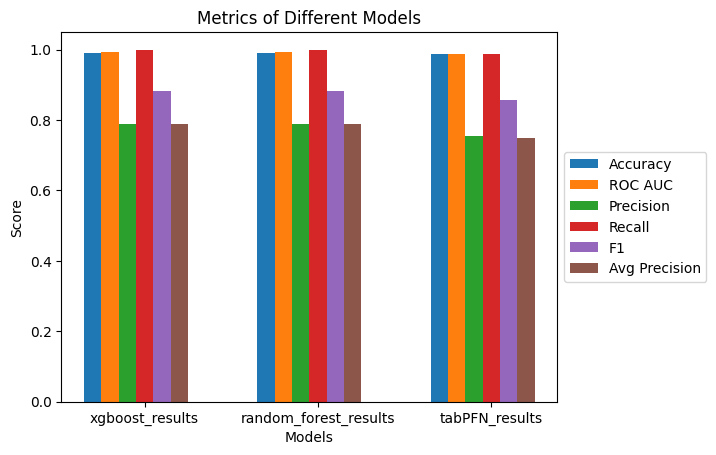

In [ ]:
plot_model_results(results)

In [ ]:
# plot shap
def get_shap_values(model, X, sample_index=10, class_index=1):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap_sample = shap_values[sample_index].values
    if shap_sample.ndim == 2:
        shap_sample = shap_sample[:, class_index]
    return pd.Series(shap_sample, index=X.columns)

def shapley_waterfall(model, X):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.waterfall(shap_values[0], max_display=14)


def shapley_beeswarm(model, X):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values)


def shapley_heatmap(model, X):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.heatmap(shap_values[:1000])

In [ ]:
# shapley_waterfall(xgboost, X_test)

PermutationExplainer explainer:  19%|█▉        | 2485/13040 [04:46<16:22, 10.75it/s]

In [ ]:
# shapley_waterfall(random_forest, X_test)

PermutationExplainer explainer:  68%|██████▊   | 8862/13040 [40:20<18:49,  3.70it/s]  

In [ ]:
# shapley_waterfall(tabPFN, X_test)

PermutationExplainer explainer:   0%|          | 5/13040 [09:53<537:25:49, 148.43s/it]


KeyboardInterrupt: 

## Get False Positives

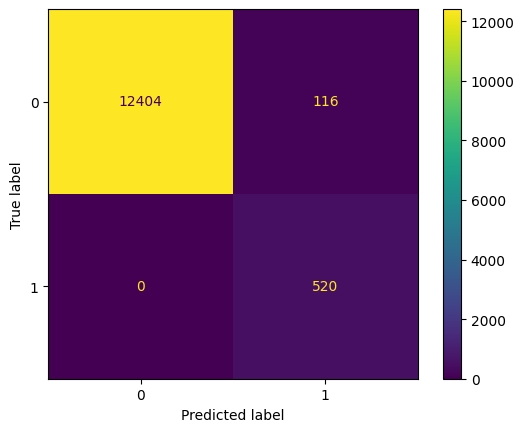

In [ ]:
xgboost_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, xgboost_pred),
                              display_labels=xgboost.classes_)
xgboost_cm.plot()
plt.show()

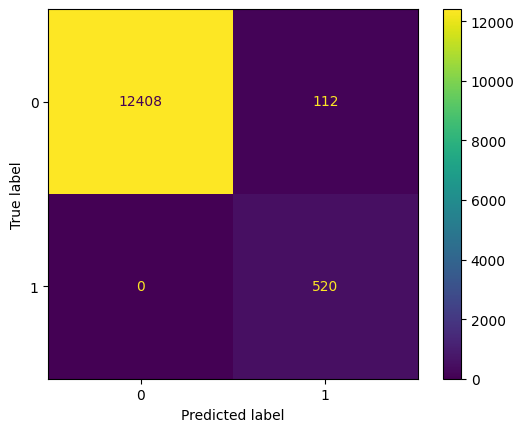

In [ ]:
random_forest_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, random_forest_pred),
                              display_labels=random_forest.classes_)
random_forest_cm.plot()
plt.show()

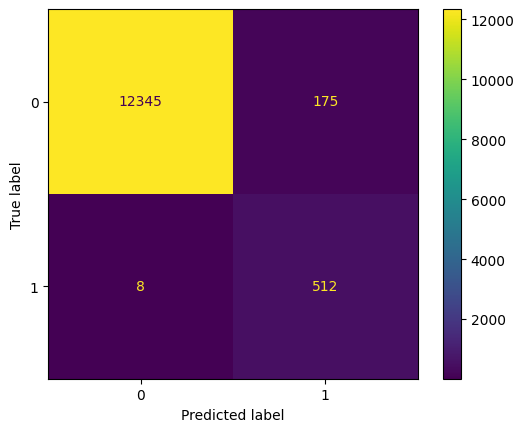

In [ ]:
tabPFN_pred = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, tabPFN_pred),
                              display_labels=tabPFN.classes_)
tabPFN_pred.plot()
plt.show()